In [36]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf import *
#from merf.evaluator import plot_bhat, plot_training_stats
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import pandas as pd
import seaborn as seas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import wbgapi as wb
from scipy import stats

seas.set(style="ticks", context="talk")
plt.style.use("dark_background")

In [38]:
indexes = ['EN.ATM.CO2E.KT',        #CO2 emissions (kt)
           'NY.GDP.MKTP.PP.KD',     #GDP per capita, PPP (constant 2017 international $)
           'SP.POP.TOTL',           #Population, total 
           'EG.FEC.RNEW.ZS',        #Renewable energy consumption (% of total final energy
           'SP.URB.TOTL.IN.ZS',     #Urban population (% of total population) 
           'NV.MNF.TECH.ZS.UN',     #Medium and high-tech manufacturing value added (% manufacturing value added)
           'NE.TRD.GNFS.ZS']        #Trade (% of GDP)

In [39]:
countries = ['Argentina',
'Armenia',
'Australia',
'Austria',
'Belgium',
'Bulgaria',
'Belarus',
'Brazil',
'Canada',
'Switzerland',
'Chile',
'China',
'Colombia',
'Czech Republic',
'Germany',
'Denmark',
'Spain',
'Estonia',
'Finland',
'France',
'United Kingdom',
'Georgia',
'Greece',
'Croatia',
'Hungary',
'India',
'Ireland',
'Iceland',
'Israel',
'Italy',
'Japan',
'Kazakhstan',
'Korea, Rep.',
'Lithuania',
'Latvia',
'Moldova',
'Mexico',
'Malaysia',
'Netherlands',
'Norway',
'New Zealand',
'Panama',
'Peru',
'Poland',
'Portugal',
'Romania',
'Russian Federation',
'Singapore',
'Serbia',
'Slovak Republic',
'Slovenia',
'Sweden',
'Turkey',
'Ukraine',
'United States',
'South Africa'] 

In [40]:
countries = [wb.economy.coder(country) for country in countries]

In [41]:
raw_dataset = wb.data.DataFrame(series = indexes, economy = countries, time = range(1994,2023), labels=True,columns='series')

In [42]:
raw_dataset.unstack(0).stack()

Country  Time  EG.FEC.RNEW.ZS  EN.ATM.CO2E.KT  \
time   economy                                                        
YR2021 ZAF       South Africa  2021             NaN             NaN   
       USA      United States  2021             NaN             NaN   
       UKR            Ukraine  2021             NaN             NaN   
       TUR            Turkiye  2021             NaN             NaN   
       SWE             Sweden  2021             NaN             NaN   
...                       ...   ...             ...             ...   
YR1994 BEL            Belgium  1994        0.939573        114900.0   
       AUT            Austria  1994       25.679455         58280.0   
       AUS          Australia  1994        8.259947        280180.0   
       ARM            Armenia  1994       17.763653          2740.0   
       ARG          Argentina  1994       10.734909        111910.0   

                NE.TRD.GNFS.ZS  NV.MNF.TECH.ZS.UN  NY.GDP.MKTP.PP.KD  \
time   economy                                                         
YR2021 ZAF           56.071227                NaN       7.881121e+11   
       USA                 NaN                NaN       2.093228e+13   
       UKR           82.621300                NaN       5.355789e+11   
       TUR           71.212724                NaN       2.657762e+12   
       SWE           88.162017                NaN       5.525622e+11   
...                        ...                ...                ...   
YR1994 BEL          113.232300          14.080100       3.740897e+11   
       AUT           65.987093          36.610757       3.129625e+11   
       AUS           36.458731          27.756124       5.726639e+11   
       ARM          112.429365          28.824233       9.053823e+09   
       ARG           18.134346          29.628354       6.224138e+11   

                SP.POP.TOTL  SP.URB.TOTL.IN.ZS  
time   economy                                  
YR2021 ZAF       60041996.0             67.847  
       USA      331893745.0             82.873  
       UKR       43814581.0             69.757  
       TUR       85042736.0             76.569  
       SWE       10415811.0             88.238  
...                     ...                ...  
YR1994 BEL       10115603.0             96.700  
       AUT        7936118.0             61.870  
       AUS       17855000.0             85.028  
       ARM        3283664.0             66.332  
       ARG       34402669.0             87.960  

[1568 rows x 9 columns]

# Overview

In [43]:
col = ['Number of variables',
'Number of observations',
'Missing cells',
'Missing cells (%)',
'Rows with Missing cells',
'Rows with Missing cells (%)',
'Duplicate rows',
'Duplicate rows (%)']

val = [len(raw_dataset.columns),
len(raw_dataset),
raw_dataset.isna().values.sum(),
(raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
len(raw_dataset) - len(raw_dataset.dropna()),
((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
raw_dataset.duplicated().sum(),
raw_dataset.duplicated().sum()]

val = list(map(round,val))

overview = pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

In [44]:
overview

Variables  Count
0          Number of variables      9
1       Number of observations   1568
2                Missing cells    362
3            Missing cells (%)     23
4      Rows with Missing cells    125
5  Rows with Missing cells (%)      8
6               Duplicate rows      0
7           Duplicate rows (%)      0

## Data preprocessing

### Renaming columns for berter readability

In [45]:
raw_dataset = raw_dataset.rename({'EG.FEC.RNEW.ZS': 'Renewable energy consumption',
'EN.ATM.CO2E.KT': 'CO2 emissions',
'NE.TRD.GNFS.ZS': 'Trade (% of GDP)',
'NV.MNF.TECH.ZS.UN': 'Perc Manufacturing Value Added',
'NY.GDP.MKTP.PP.KD': 'GDP per capita',
'SP.POP.TOTL': 'Total Population',
'SP.URB.TOTL.IN.ZS': 'Urban Population',
},axis = 1)

In [46]:
raw_dataset.head()

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2021  South Africa  2021                           NaN   
        YR2020  South Africa  2020                           NaN   
        YR2019  South Africa  2019                         10.50   
        YR2018  South Africa  2018                         10.19   
        YR2017  South Africa  2017                         10.45   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2021            NaN         56.071227   
        YR2020            NaN         51.126846   
        YR2019  439640.014648         54.150246   
        YR2018  434350.006104         54.507584   
        YR2017  435649.993896         53.535932   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2021                             NaN    7.881121e+11   
        YR2020                             NaN    7.511939e+11   
        YR2019                       24.428034    8.028319e+11   
        YR2018                       24.428034    8.019253e+11   
        YR2017                       24.428034    7.901706e+11   

                Total Population  Urban Population  
economy time                                        
ZAF     YR2021        60041996.0            67.847  
        YR2020        59308690.0            67.354  
        YR2019        58558267.0            66.856  
        YR2018        57792520.0            66.355  
        YR2017        57009751.0            65.850

### Missing value check


In [47]:
raw_dataset.isna().sum()

Country                             0
Time                                0
Renewable energy consumption      112
CO2 emissions                     112
Trade (% of GDP)                   14
Perc Manufacturing Value Added    112
GDP per capita                     12
Total Population                    0
Urban Population                    0
dtype: int64

In [48]:
raw_dataset = raw_dataset.dropna()

### Outlier detection and treatment

In [49]:
def outlier_treatment(dataset):
    """
    
    Values lying outside 3SD are considered as outliers for this analysis
    Outlier values are treated with mean of that column
    
    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    Dataframe with treated outlier values
    """
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset,outlier_summary

raw_dataset,outlier_summary = outlier_treatment(raw_dataset)

outlier_summary

Variables  No. of Outliers
0    Renewable energy consumption               14
1                   CO2 emissions               43
2                Trade (% of GDP)               27
3  Perc Manufacturing Value Added               10
4                  GDP per capita               38
5                Total Population               52
6                Urban Population               10

### Calculating Column of Intrest

In [50]:
raw_dataset

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2019  South Africa  2019                     10.500000   
        YR2018  South Africa  2018                     10.190000   
        YR2017  South Africa  2017                     10.450000   
        YR2016  South Africa  2016                     10.530000   
        YR2015  South Africa  2015                     10.280000   
...                      ...   ...                           ...   
ARG     YR1998     Argentina  1998                     11.343009   
        YR1997     Argentina  1997                     10.999073   
        YR1996     Argentina  1996                     10.193856   
        YR1995     Argentina  1995                     11.205185   
        YR1994     Argentina  1994                     10.734909   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2019  439640.014648         54.150246   
        YR2018  434350.006104         54.507584   
        YR2017  435649.993896         53.535932   
        YR2016  425140.014648         55.861258   
        YR2015  424809.997559         56.726676   
...                       ...               ...   
ARG     YR1998  132670.000000         23.350028   
        YR1997  126120.000000         23.336179   
        YR1996  122550.000000         21.506468   
        YR1995  112890.000000         19.771423   
        YR1994  111910.000000         18.134346   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2019                       24.428034    8.028319e+11   
        YR2018                       24.428034    8.019253e+11   
        YR2017                       24.428034    7.901706e+11   
        YR2016                       24.428034    7.811255e+11   
        YR2015                       24.428034    7.759688e+11   
...                                        ...             ...   
ARG     YR1998                       30.443321    7.164454e+11   
        YR1997                       30.983214    6.898836e+11   
        YR1996                       28.563551    6.381250e+11   
        YR1995                       27.200513    6.047048e+11   
        YR1994                       29.628354    6.224138e+11   

                Total Population  Urban Population  
economy time                                        
ZAF     YR2019        58558267.0            66.856  
        YR2018        57792520.0            66.355  
        YR2017        57009751.0            65.850  
        YR2016        56207649.0            65.341  
        YR2015        55386369.0            64.828  
...                          ...               ...  
ARG     YR1998        36063451.0            88.759  
        YR1997        35657438.0            88.564  
        YR1996        35246376.0            88.366  
        YR1995        34828168.0            88.164  
        YR1994        34402669.0            87.960  

[1443 rows x 9 columns]

In [51]:
raw_dataset['CO2 per Capita'] = raw_dataset['CO2 emissions']/raw_dataset['Total Population']

### Log Trasforming the data

In [52]:
for col in [col for col in raw_dataset.columns[2:]]:
    raw_dataset[col] = np.log10(raw_dataset[col] + 1)

In [53]:
processed_df = raw_dataset

## Exploratory Data Analysis

### Data Summary


In [54]:
processed_df.describe(include='all')

Country  Time  Renewable energy consumption  CO2 emissions  \
count           1443  1443                   1443.000000    1443.000000   
unique            56    26                           NaN            NaN   
top     South Africa  2019                           NaN            NaN   
freq              26    56                           NaN            NaN   
mean             NaN   NaN                      1.115691       4.949772   
std              NaN   NaN                      0.391837       0.672622   
min              NaN   NaN                      0.123852       3.212454   
25%              NaN   NaN                      0.867761       4.583097   
50%              NaN   NaN                      1.148911       4.843239   
75%              NaN   NaN                      1.445530       5.525500   
max              NaN   NaN                      1.802568       6.580932   

        Trade (% of GDP)  Perc Manufacturing Value Added  GDP per capita  \
count        1443.000000                     1443.000000     1443.000000   
unique               NaN                             NaN             NaN   
top                  NaN                             NaN             NaN   
freq                 NaN                             NaN             NaN   
mean            1.863056                        1.509789       11.571755   
std             0.218728                        0.231886        0.640809   
min             1.158007                        0.690589        9.954466   
25%             1.733932                        1.405031       11.180345   
50%             1.866179                        1.569113       11.572287   
75%             2.014420                        1.674872       12.087101   
max             2.358700                        1.924619       12.960968   

        Total Population  Urban Population  CO2 per Capita  
count        1443.000000       1443.000000     1443.000000  
unique               NaN               NaN             NaN  
top                  NaN               NaN             NaN  
freq                 NaN               NaN             NaN  
mean            7.179238          1.853878        0.003108  
std             0.607142          0.090003        0.002062  
min             5.427273          1.475715        0.000323  
25%             6.721371          1.797787        0.001783  
50%             7.035915          1.872180        0.002858  
75%             7.675878          1.916499        0.003929  
max             8.516311          2.004321        0.020694

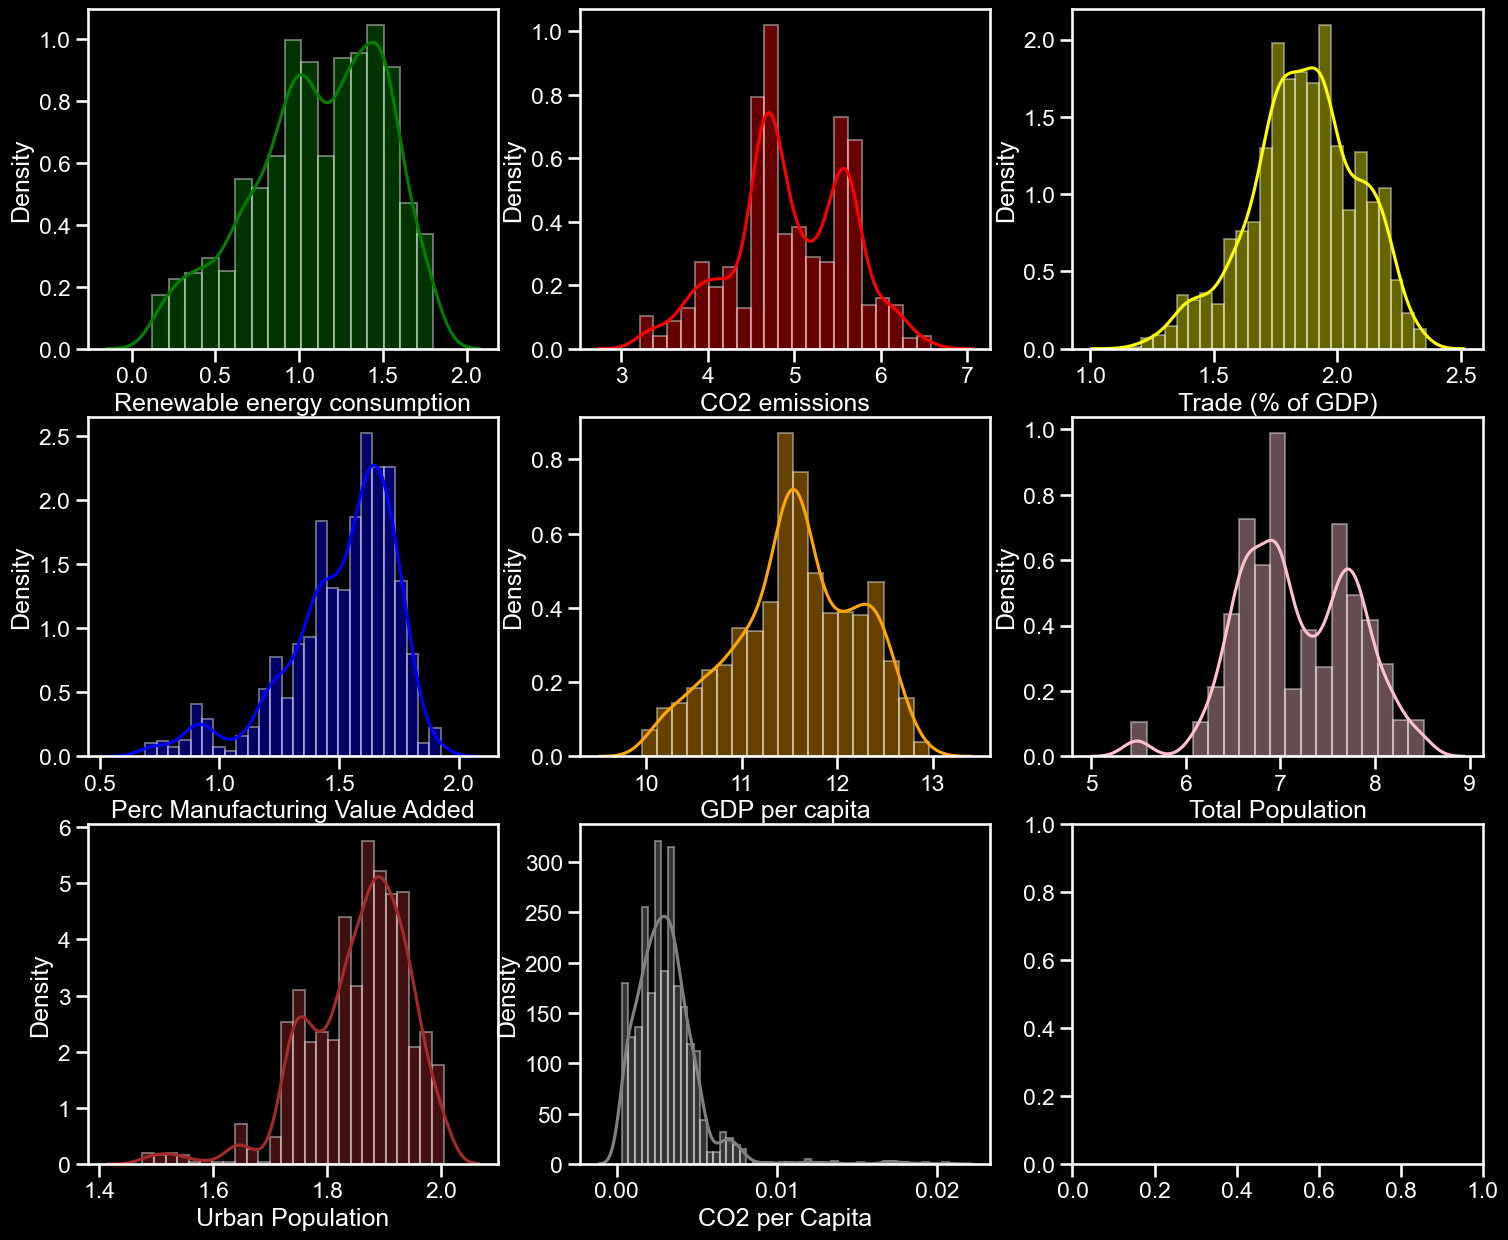

In [55]:
%matplotlib inline

n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[2:]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols])

### Pair Plots

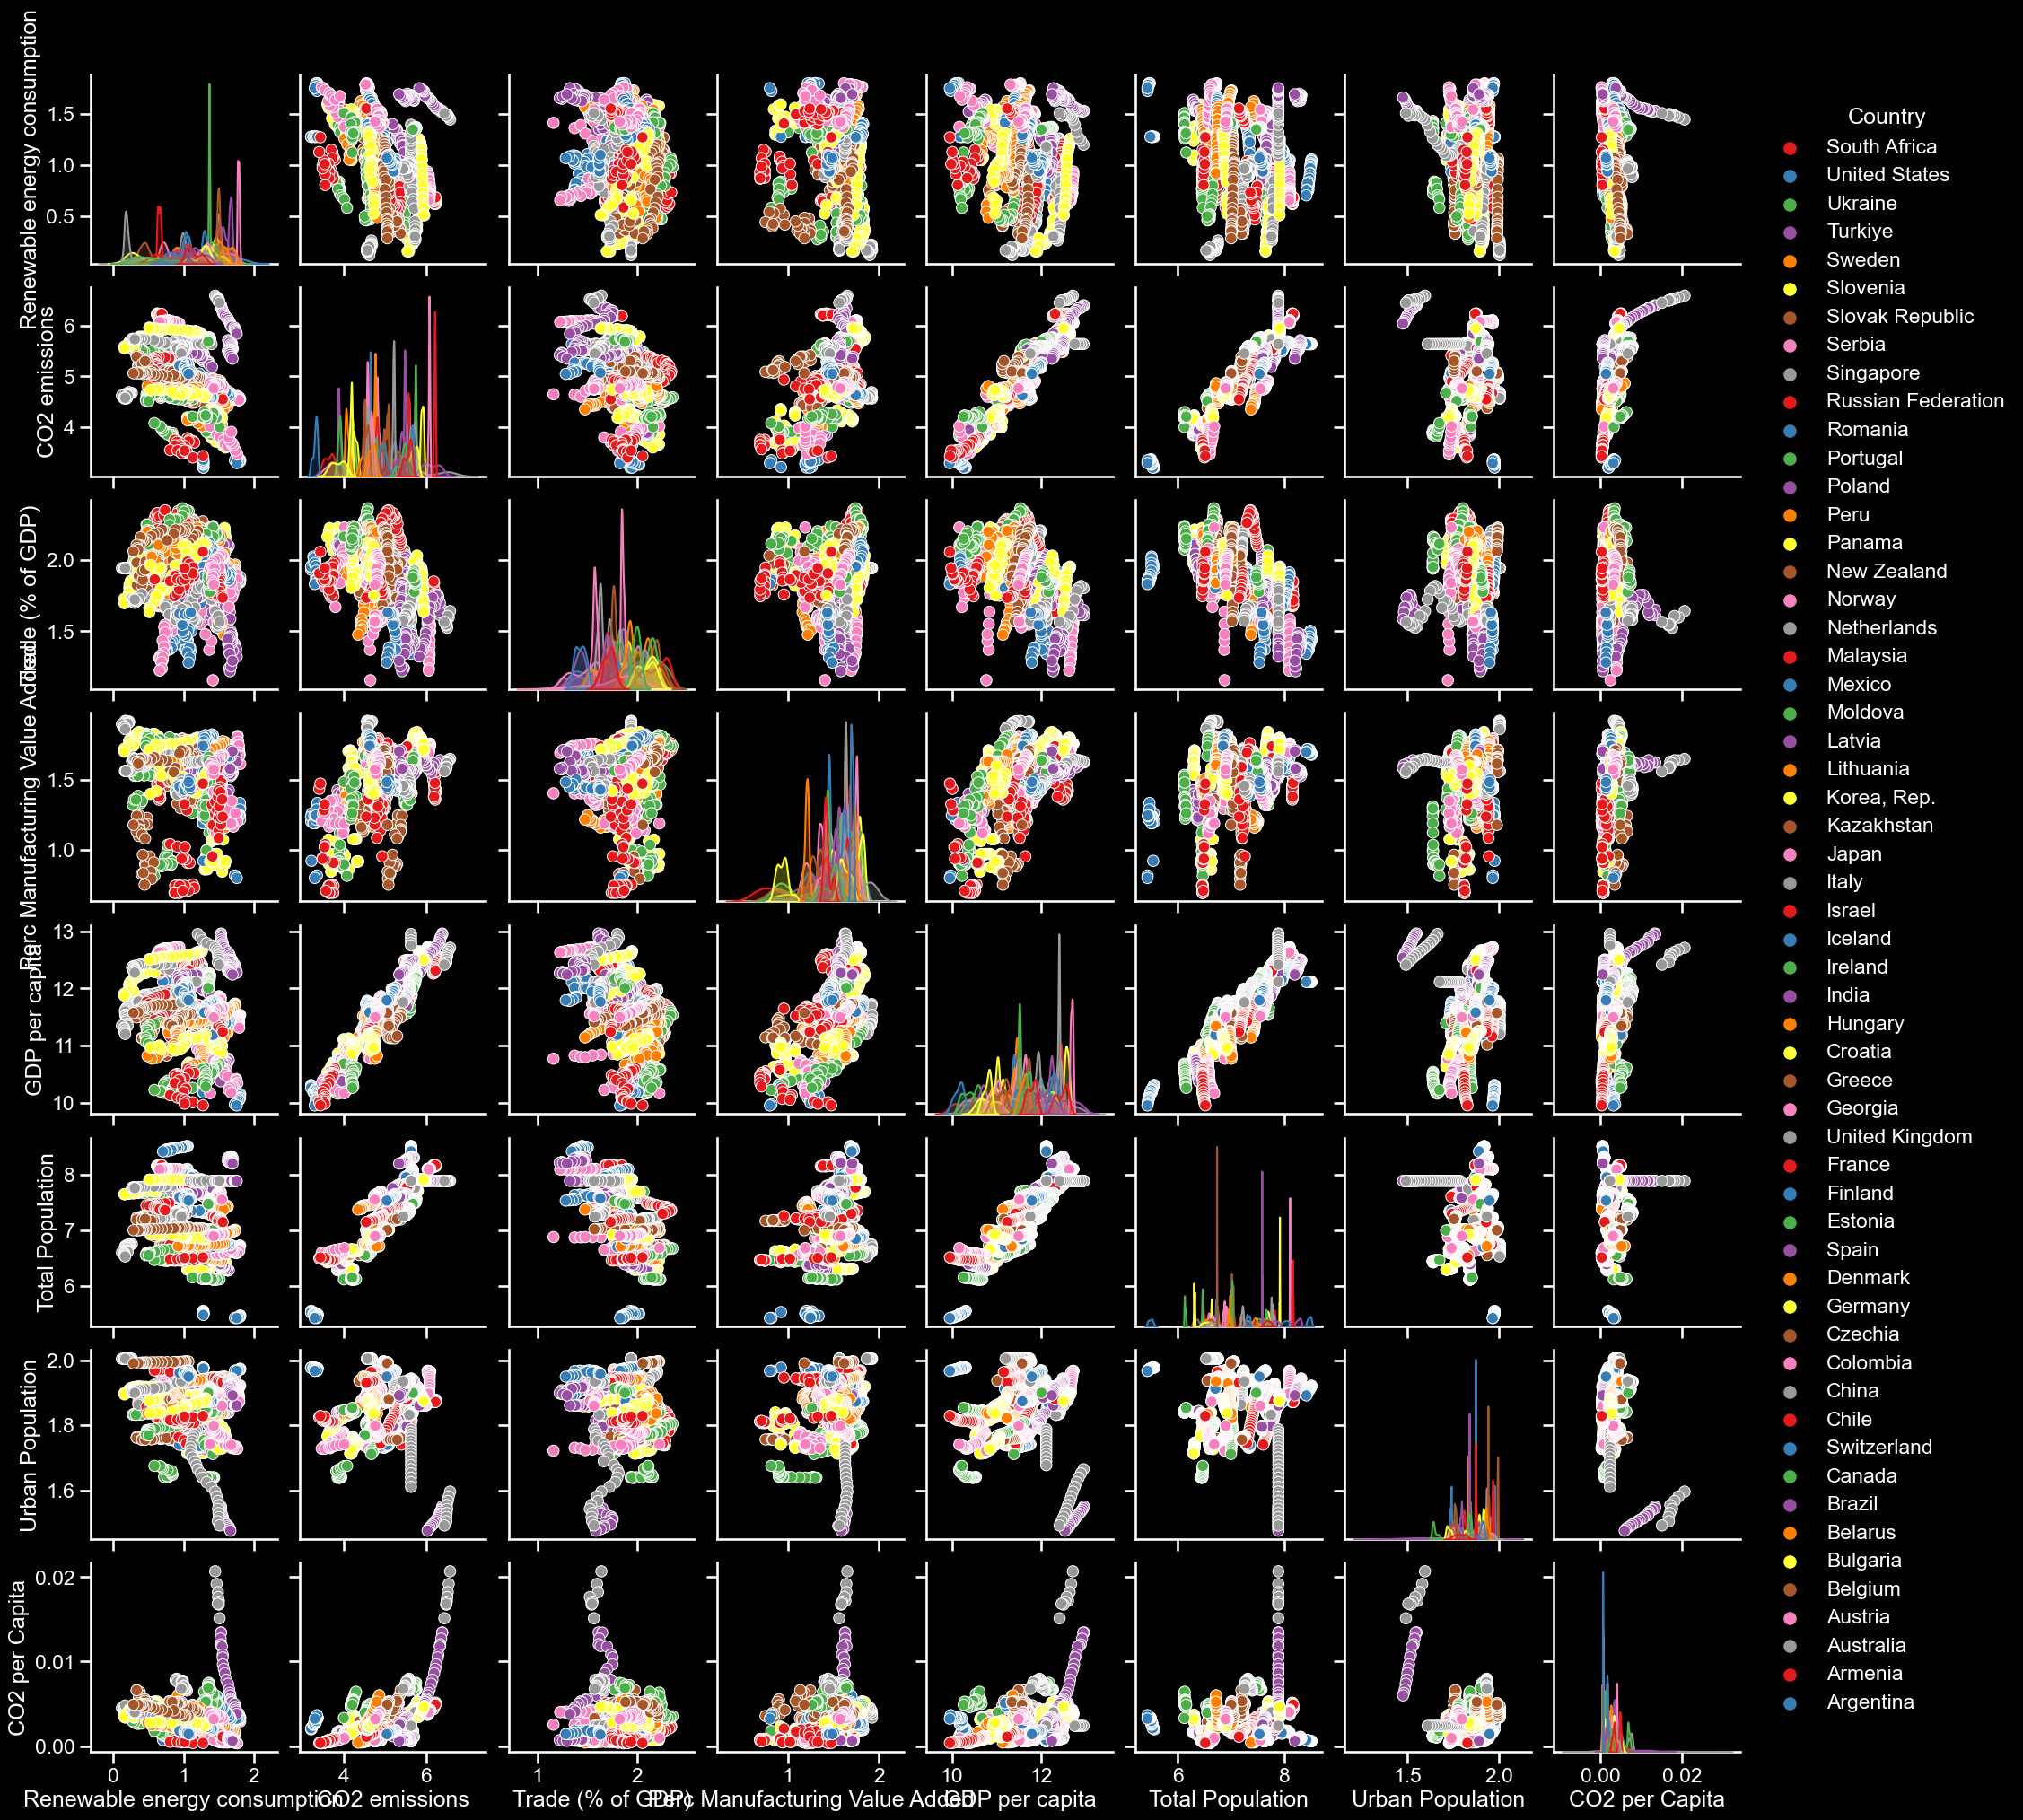

In [56]:

seas.pairplot(data=processed_df,  hue='Country',palette="Set1")


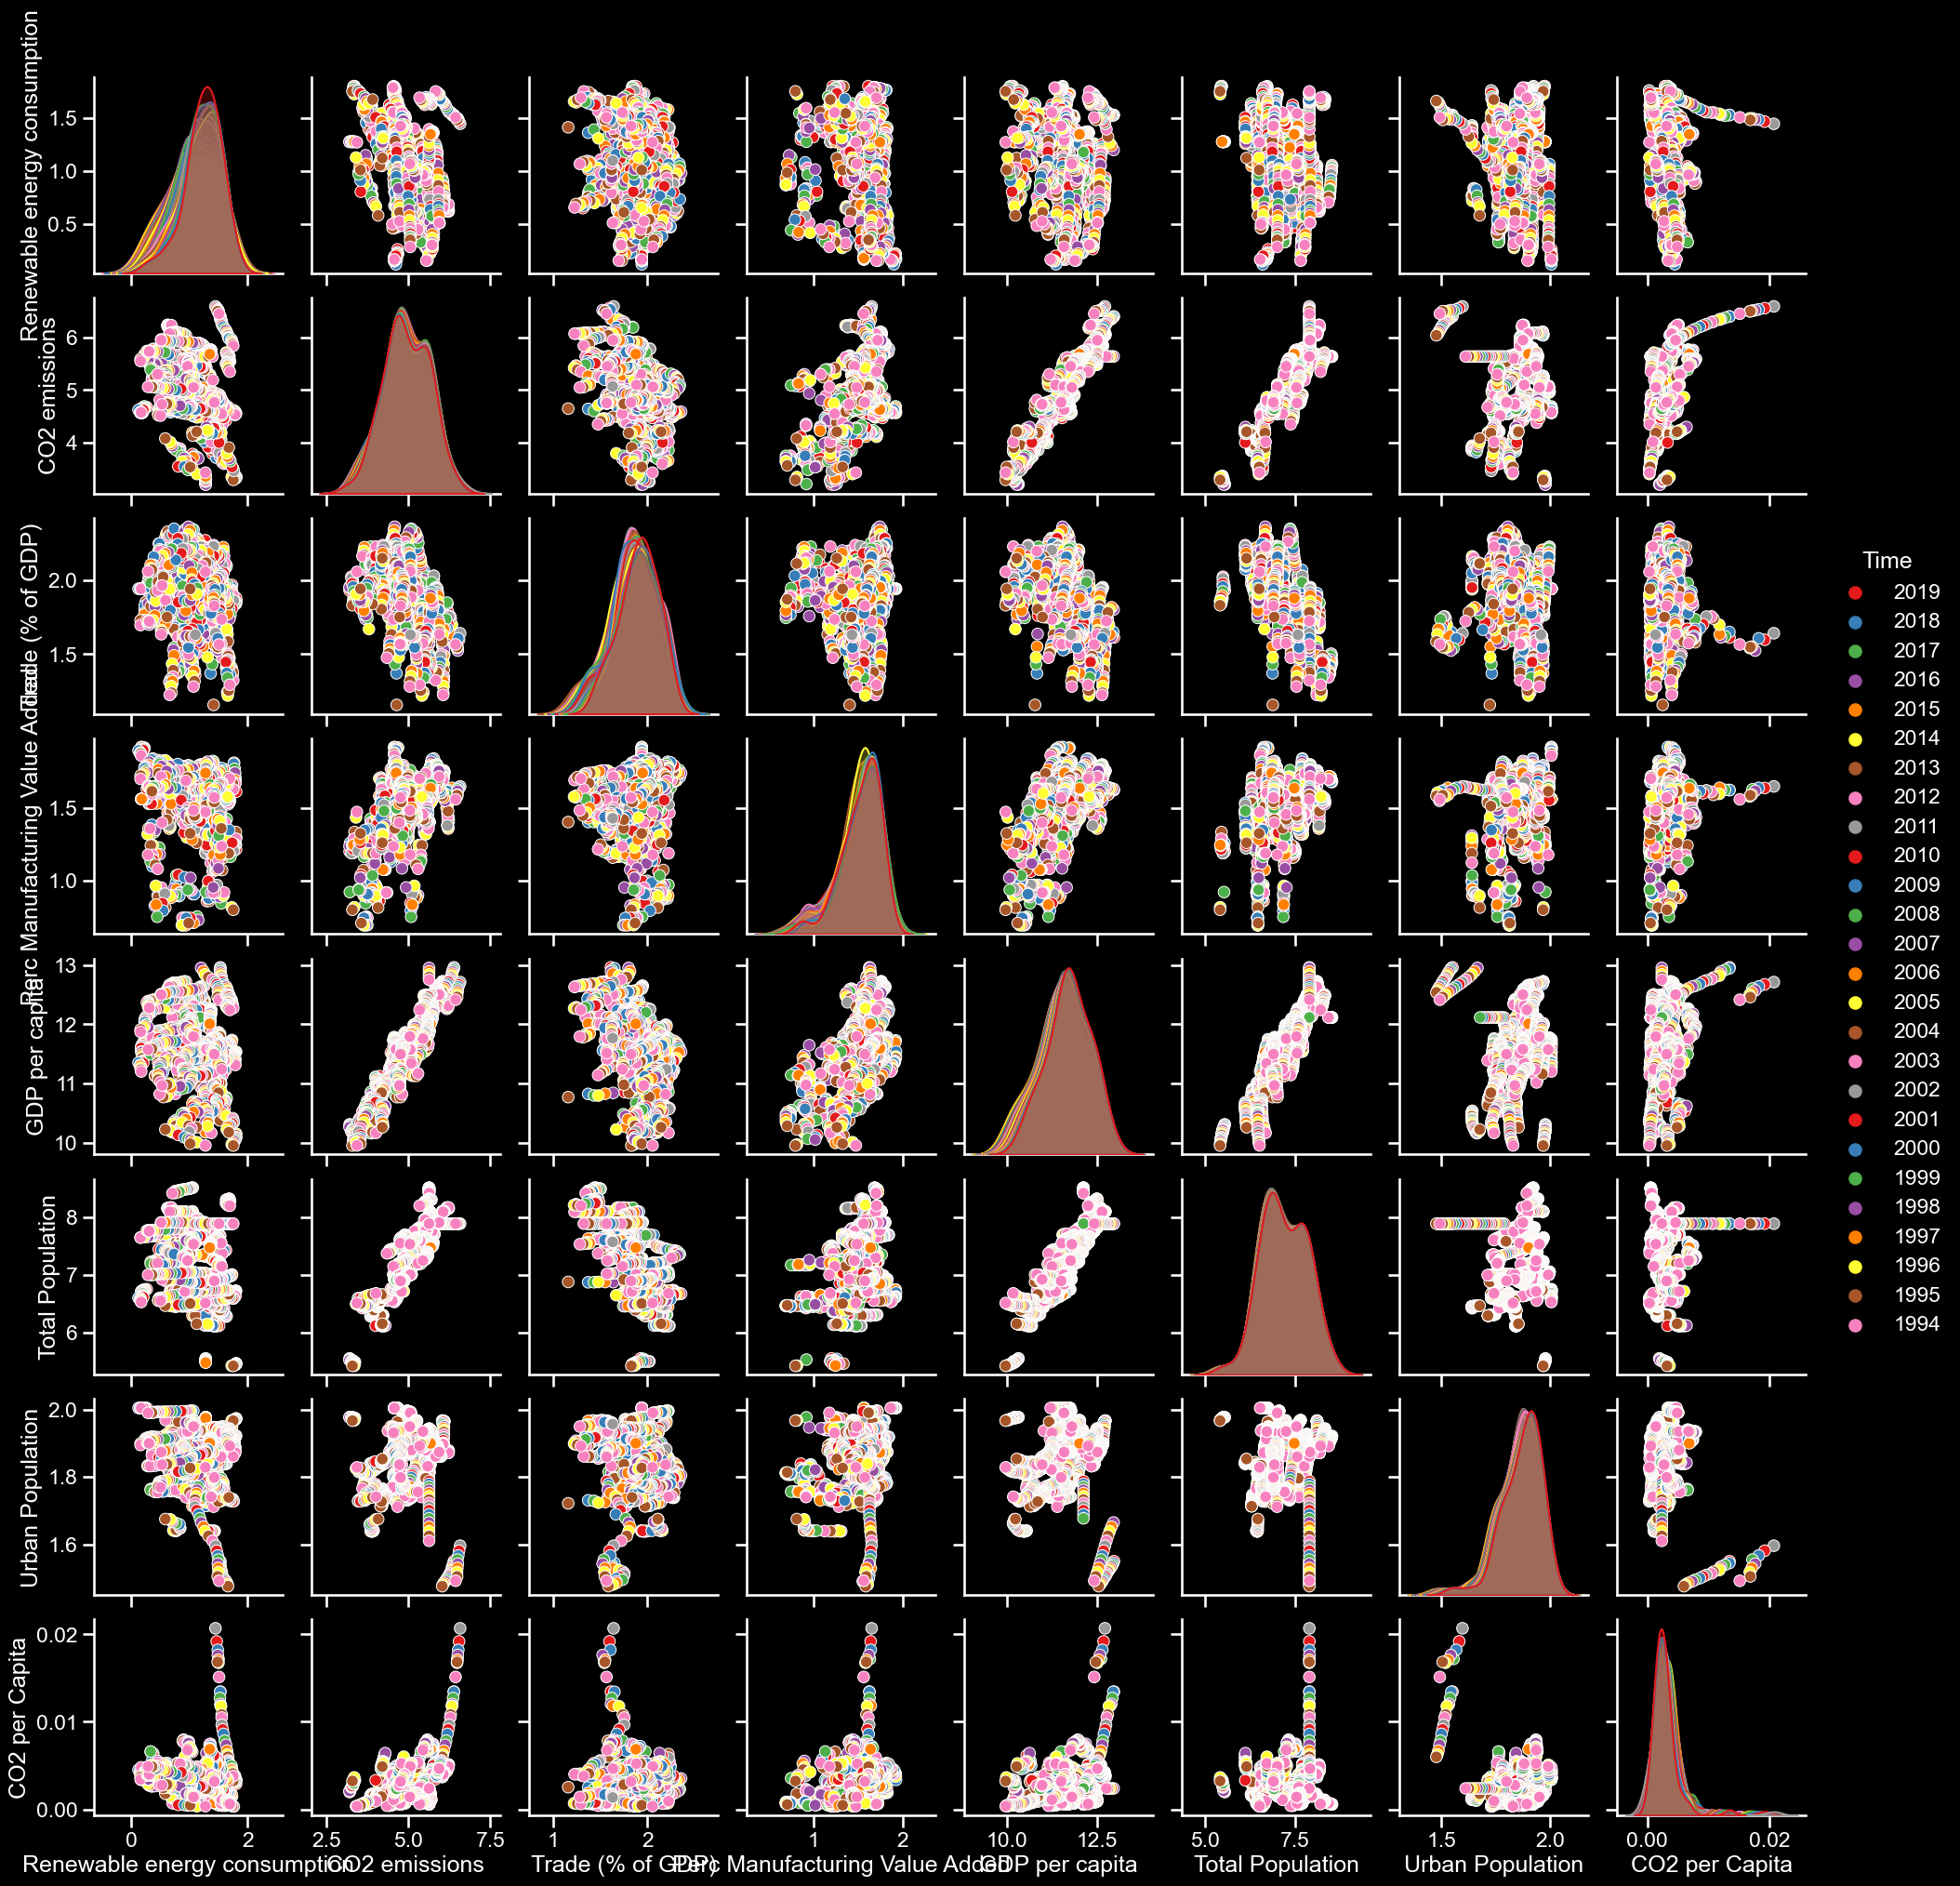

In [57]:
seas.pairplot(data=processed_df,  hue='Time',palette="Set1")


## Data Spliting

In [58]:
X = processed_df.iloc[:,:-1]
y = processed_df.iloc[:,-1]
  
# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)


In [59]:
processed_df

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2019  South Africa  2019                      1.060698   
        YR2018  South Africa  2018                      1.048830   
        YR2017  South Africa  2017                      1.058805   
        YR2016  South Africa  2016                      1.061829   
        YR2015  South Africa  2015                      1.052309   
...                      ...   ...                           ...   
ARG     YR1998     Argentina  1998                      1.091421   
        YR1997     Argentina  1997                      1.079148   
        YR1996     Argentina  1996                      1.048980   
        YR1995     Argentina  1995                      1.086544   
        YR1994     Argentina  1994                      1.069480   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2019       5.643098          1.741547   
        YR2018       5.637841          1.744352   
        YR2017       5.639139          1.736683   
        YR2016       5.628533          1.754816   
        YR2015       5.628196          1.761377   
...                       ...               ...   
ARG     YR1998       5.122776          1.386499   
        YR1997       5.100787          1.386252   
        YR1996       5.088317          1.352307   
        YR1995       5.052659          1.317466   
        YR1994       5.048873          1.281814   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2019                        1.405313       11.904625   
        YR2018                        1.405313       11.904134   
        YR2017                        1.405313       11.897721   
        YR2016                        1.405313       11.892721   
        YR2015                        1.405313       11.889844   
...                                        ...             ...   
ARG     YR1998                        1.497528       11.855183   
        YR1997                        1.504922       11.838776   
        YR1996                        1.470757       11.804906   
        YR1995                        1.450257       11.781543   
        YR1994                        1.486124       11.794079   

                Total Population  Urban Population  CO2 per Capita  
economy time                                                        
ZAF     YR2019          7.767588          1.831588        0.003248  
        YR2018          7.761872          1.828370        0.003252  
        YR2017          7.755949          1.825101        0.003306  
        YR2016          7.749795          1.821782        0.003273  
        YR2015          7.743403          1.818411        0.003318  
...                          ...               ...             ...  
ARG     YR1998          7.557067          1.953078        0.001595  
        YR1997          7.552150          1.952133        0.001533  
        YR1996          7.547114          1.951172        0.001507  
        YR1995          7.541931          1.950190        0.001405  
        YR1994          7.536592          1.949195        0.001410  

[1443 rows x 10 columns]

In [61]:
processed_df

Country  Time  Renewable energy consumption  \
economy time                                                       
ZAF     YR2019  South Africa  2019                      1.060698   
        YR2018  South Africa  2018                      1.048830   
        YR2017  South Africa  2017                      1.058805   
        YR2016  South Africa  2016                      1.061829   
        YR2015  South Africa  2015                      1.052309   
...                      ...   ...                           ...   
ARG     YR1998     Argentina  1998                      1.091421   
        YR1997     Argentina  1997                      1.079148   
        YR1996     Argentina  1996                      1.048980   
        YR1995     Argentina  1995                      1.086544   
        YR1994     Argentina  1994                      1.069480   

                CO2 emissions  Trade (% of GDP)  \
economy time                                      
ZAF     YR2019       5.643098          1.741547   
        YR2018       5.637841          1.744352   
        YR2017       5.639139          1.736683   
        YR2016       5.628533          1.754816   
        YR2015       5.628196          1.761377   
...                       ...               ...   
ARG     YR1998       5.122776          1.386499   
        YR1997       5.100787          1.386252   
        YR1996       5.088317          1.352307   
        YR1995       5.052659          1.317466   
        YR1994       5.048873          1.281814   

                Perc Manufacturing Value Added  GDP per capita  \
economy time                                                     
ZAF     YR2019                        1.405313       11.904625   
        YR2018                        1.405313       11.904134   
        YR2017                        1.405313       11.897721   
        YR2016                        1.405313       11.892721   
        YR2015                        1.405313       11.889844   
...                                        ...             ...   
ARG     YR1998                        1.497528       11.855183   
        YR1997                        1.504922       11.838776   
        YR1996                        1.470757       11.804906   
        YR1995                        1.450257       11.781543   
        YR1994                        1.486124       11.794079   

                Total Population  Urban Population  CO2 per Capita  
economy time                                                        
ZAF     YR2019          7.767588          1.831588        0.003248  
        YR2018          7.761872          1.828370        0.003252  
        YR2017          7.755949          1.825101        0.003306  
        YR2016          7.749795          1.821782        0.003273  
        YR2015          7.743403          1.818411        0.003318  
...                          ...               ...             ...  
ARG     YR1998          7.557067          1.953078        0.001595  
        YR1997          7.552150          1.952133        0.001533  
        YR1996          7.547114          1.951172        0.001507  
        YR1995          7.541931          1.950190        0.001405  
        YR1994          7.536592          1.949195        0.001410  

[1443 rows x 10 columns]

In [68]:
max_iter = 200
cv = KFold(n_splits=5, shuffle=True)
mse_rf = []
mse_rfplus = []
mse_mrf = []
mse_mrf_uranium = []
mse_mrf_uranium_both = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth

    # Mixed Effects Random Forest Training
    mrf = MERF(max_iterations=max_iter)
    X_train =  train.iloc[:,2:8]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    mrf.fit(X_train, Z_train, clusters_train, y_train)
    
    # Mixed Effects Random Forest Test
    X_test = train.iloc[:,2:8]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = mrf.predict(X_test, Z_test, clusters_test)
    mse_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

#train.iloc[:,2:8]

INFO     [merf.py:307] Training GLL is -3718.361220657047 at iteration 1.
INFO     [merf.py:307] Training GLL is -7436.708987702125 at iteration 2.
INFO     [merf.py:307] Training GLL is -11154.849651824636 at iteration 3.
INFO     [merf.py:307] Training GLL is -14868.072763640468 at iteration 4.
INFO     [merf.py:307] Training GLL is -18468.924596408295 at iteration 5.
INFO     [merf.py:307] Training GLL is -20898.555199532653 at iteration 6.
INFO     [merf.py:307] Training GLL is -21066.47020100694 at iteration 7.
INFO     [merf.py:307] Training GLL is -21094.422548832274 at iteration 8.
INFO     [merf.py:307] Training GLL is -21130.330141044964 at iteration 9.
INFO     [merf.py:307] Training GLL is -21074.3696843393 at iteration 10.
INFO     [merf.py:307] Training GLL is -21115.95821611165 at iteration 11.
INFO     [merf.py:307] Training GLL is -21061.66955300151 at iteration 12.
INFO     [merf.py:307] Training GLL is -20996.187264611523 at iteration 13.
INFO     [merf.py:307] Train

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1154 but corresponding boolean dimension is 289

## Modeling

In [60]:
max_iter = 200
cv = KFold(n_splits=5, shuffle=True)
mse_rf = []
mse_rfplus = []
mse_mrf = []
mse_mrf_uranium = []
mse_mrf_uranium_both = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']
        
    # Mixed Effects Random Forest Training
    mrf = MERF(n_estimators=100, max_iterations=max_iter)
    X_train =  train.iloc[:,:]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test
    X_test =  test[['floor']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['county']
    yhat_mrf = mrf.predict(X_test, Z_test, clusters_test)
    mse_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))
    
    # Mixed Effects Random Forest Training with uranium RE
    mrf_uranium = MERF(n_estimators=100, max_iterations=max_iter)
    X_train =  train[['floor']]
    Z_train = np.array((np.ones(len(X_train)), train['Uppm'])).T
    clusters_train = train['county']
    y_train = train['log_radon']
    mrf_uranium.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with uranium RE
    X_test =  test[['floor']]
    Z_test = np.array((np.ones(len(X_test)), test['Uppm'])).T
    clusters_test = test['county']
    yhat_mrf_uranium = mrf_uranium.predict(X_test, Z_test, clusters_test)
    mse_mrf_uranium.append(np.sqrt(np.sum((y - yhat_mrf_uranium)**2)) / len(y))
    
    # Mixed Effects Random Forest Training with Uranium as both FE and RE
    mrf_uranium_both = MERF(n_estimators=100, max_iterations=max_iter)
    X_train =  train[['floor', 'Uppm']]
    Z_train = np.array((np.ones(len(X_train)), train['Uppm'])).T
    clusters_train = train['county']
    y_train = train['log_radon']
    mrf_uranium_both.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with County-level covariate (uranium)
    X_test =  test[['floor', 'Uppm']]
    Z_test = np.array((np.ones(len(X_test)), test['Uppm'])).T
    clusters_test = test['county']
    yhat_mrf_uranium_both = mrf_uranium_both.predict(X_test, Z_test, clusters_test)
    mse_mrf_uranium_both.append(np.sqrt(np.sum((y - yhat_mrf_uranium_both)**2)) / len(y))


KeyError: 'C'